## 2 Learning a policy via MC - Policy Iteration
For the following work with last weeks implementation of your own gridworld! You may revise/change pieces of it, or ask other groups for access to their implementation of course.

* Implement tabular MC-estimate Policy Iteration
* Measure average Return-per-Episode and plot it against (1) episodes sam-
pled, and (2) wallclock-time For an outstanding submission:
* Visualize the State-Action Values in your gridworld during training at regular intervals, and provide a visualization of them (e.g. a series of images, best combine them into a short video clip)

### GridWorld Code (refactored) From HW 1:

#### Global Variables, Static Functions

In [2]:
import random
%load_ext line_profiler
# Directions as a faux enum, this is the set A of actions
UP = 0
LEFT = 1
DOWN = 2
RIGHT = 3
DIRECTIONS = [UP, LEFT, DOWN, RIGHT]

def distance_between_states(state_1, state_2):
    """Calculate Manhattan distance between states. This is useful for the 
       agent's policy, but also useful for positioning walls are warps away 
       from the start and end state."""
    return abs(state_2[0] - state_1[0]) + abs(state_2[1] - state_1[1])
    
def direction_arithmetic(curr_pos, direction):
    """Calculate the resulting state coordinates given a state and direction."""
    row, col = curr_pos
    if direction == UP:
        row = row - 1
    elif direction == LEFT:
        col = col - 1
    elif direction == DOWN:
        row = row + 1
    elif direction == RIGHT:
        col = col + 1
    else:
        raise Exception(f"Unrecognized direction: {direction}")
    return (row, col)

def average(l):
    return sum(l)/len(l)

def print_matrix(m):
    for row in m:
        for col in row:
            print(f"{col:.3f}", end='\t')
        print()

#### Agent Classes

In [3]:
class Agent:
    """This base agent class just takes random actions."""
    
    def __init__(self, state=(0, 0)):
        self.state = state
        self.available_actions = []
        self.available_next_states = []
        
    def get_action_from_policy(self):
        return random.choice(self.available_actions)
    
    def take_action(self, action):
        action_index = self.available_action.index(action)
        self.state = self.available_next_states[action_index]
        
    def reset(self, state=(0, 0)):
        self.state = state
        self.available_actions = []
        self.available_next_states = []
        
class MagneticAgent(Agent):
    """The MagneticAgent likes to choose actions that bring it closer
       to the win state, regardless of what obstacles are in the way."""

    def __init__(self, win_state=(0, 0), start_state=(0, 0)):
        self.state = start_state
        self.win_state = win_state
        self.available_actions = []
        self.available_next_states = []
    
    def get_action_from_policy(self):
        
        """Get possible actions/next states, and pick one. The probability of choosing a direction is
           inversely proportional to the distance that the resulting state is from the terminal state"""
        distances_to_win_states = list(map(lambda s : distance_between_states(s, self.win_state), self.available_next_states))
        reciprocals_of_distances = list(map(lambda d : 1/(d+1), distances_to_win_states))
        sum_of_reciprocals = sum(reciprocals_of_distances)
        normalized_probabilities = list(map(lambda r : r/sum_of_reciprocals, reciprocals_of_distances))
        return random.choices(self.available_actions, weights=reciprocals_of_distances)[0]


#### GridWorld Class

In [4]:
class GridWorld:
 
    def __init__(self, height, width, complex=False):
        """Initialize the grid with properties we expect to not change
           during the game."""
        self.height = height
        self.width = width
        self.complex = complex
        self.walls = []
        self.warps = []
        self.grid = [[0 for _ in range(width)] for _ in range(height)]
        self.agent = Agent()
        
        self.reset()
        
    def set_agent(self, agent):
        self.agent = agent
        
    def random_position(self):
        """Pick out a random tile."""
        rand_row = random.randint(0, self.height-1)
        rand_col = random.randint(0, self.width-1)
        return (rand_row, rand_col)
    
    def tile_is_open(self, tile):
        return self.grid[tile[0]][tile[1]] == " "
    
    def spawn_complexity_randomly(self, complexity, seed=None):
        random.seed(seed)
        tile = self.random_position()
        if (self.tile_is_open(tile) and
            distance_between_states(tile, self.win_state) > 1 and
            distance_between_states(tile, self.agent.state) > 1):
            if complexity == "wall":
                self.walls.append(tile)
                self.grid[tile[0]][tile[1]] = "█"
            elif complexity == "warp":
                self.warps.append(tile)
                self.grid[tile[0]][tile[1]] = "*"
            else:
                raise Exception(f"Unrecognized complexity: {complexity}!")
        
    def reset(self):
        """Reset the GridWorld. Send the agent back to the corner. Set up
           walls and warps"""
        for i in range(len(self.grid)):
            for j in range(len(self.grid[i])):
                self.grid[i][j] = " "
        self.win_state = (self.height-1, self.width-1)
        self.grid[self.win_state[0]][self.win_state[1]] = "W"
        
        self.agent.reset()
        self.grid[self.agent.state[0]][self.agent.state[1]] = "A"
        self.update_valid_next_actions_and_states()

        
        """Add complexities (2 walls, 2 warps). the location is random, but consistent for
           a given grid size. This helps make the value function more specific to one grid."""
        self.walls = []
        self.warps = []
        if self.complex:
            iteration = 0
            while len(self.walls) < 2:
                self.spawn_complexity_randomly("wall", iteration)
                iteration += 1
            while len(self.warps) < 2:
                self.spawn_complexity_randomly("warp", iteration)
                iteration += 1
            random.seed()
                
    def valid(self, state):
        """Checks to see if a state lies within the bounds of the grid."""
        row, col = state
        return (row >=0 and row < self.height) and (col >=0 and col < self.width)
    
    def update_valid_next_actions_and_states(self):
        """From the agent's state or a given state, look around and see what directions
           are possible."""
        valid_actions = []
        valid_states = []
        for direction in DIRECTIONS:
            target_state = direction_arithmetic(self.agent.state, direction)
            if self.valid(target_state):
                valid_actions.append(direction)
                valid_states.append(target_state)
        self.agent.available_actions = valid_actions
        self.agent.available_next_states = valid_states
        
    def reward_from_state(self, state, direction):
        """Reward function given state and action. Penalizes warps more than walls.
           No penalty for simply moving to an open space."""
        target_state = direction_arithmetic(state, direction)
        if target_state == self.win_state:
            return 1
        if target_state in self.walls:
            return -0.25
        if target_state in self.warps:
            return -0.5
        else:
            return 0

    def reward(self, direction):
        """Same as above, but from the agent's state."""
        return self.reward_from_state(self.agent.state, direction)
    
        
    def move(self, direction):
        """Try to move in a given direction. Hitting a wall will leave the agent where
           it is. Hitting a warp will send the agent back to the starting corner."""
        target_state = direction_arithmetic(self.agent.state, direction)
        if self.valid(target_state) and target_state not in self.walls:
            self.grid[self.agent.state[0]][self.agent.state[1]] = " "
            
            # go back to the beginning if you hit a warp tile
            if target_state in self.warps:
                self.agent.state = (0, 0)
            else:
                self.agent.state = target_state
            self.grid[self.agent.state[0]][self.agent.state[1]] = "A"
            self.update_valid_next_actions_and_states()
    

    def __repr__(self):
        """For printing but mainly for debugging"""
        s = ""
        for row in range(self.height):
            s += "==" * (self.width) + "="
            s += "\n"
            for col in range(self.width):
                s += f"|{self.grid[row][col]}"
            s +="|\n"
        s += "==" * (self.width) + "="
        return s

### Run Episodes

In [14]:
def monte_carlo_simulation(gridworld, agent, gamma=0.95, num_episodes=100, track=False):
    V = [[float("-inf") for _ in range(gridworld.width)] for _ in range(gridworld.height)]
    returns = [[ [] for _ in range(gridworld.width)] for _ in range(gridworld.height)]
    gridworld.set_agent(agent)
    
    completed_episodes = 0
    while completed_episodes < num_episodes:
        time_step = 0
        visited_states = list()
        gridworld.reset()

        """the agent should act as long as it hasn't reached the terminal state"""
        while gridworld.agent.state != gridworld.win_state:

            selected_action = gridworld.agent.get_action_from_policy()

            """Calculate the reward for the move. Incorporate this reward into the rewards of all states
               that have been visited so far this episode."""
            reward_from_action = gridworld.reward(selected_action)
            for i in range(len(visited_states)):
                state_in_history = visited_states[-1*i] # moving backwards in time
                state_in_history[1] += gamma**i * reward_from_action # element 1 is the reward
            visited_states.append([gridworld.agent.state, reward_from_action]) # ( (0, 0), 0 )

            """Make the move and increase the time step."""
            gridworld.move(selected_action)
            time_step += 1

        """After every episode, add the rewards for each visited state into the returns 3-D array (indexed
           by (row, col)). Then recalculate V based on the ever growing returns lists. As they grow, the
           values in V should converge."""
        for visited_state in visited_states:
            state = visited_state[0]
            rewards = visited_state[1]
            returns[state[0]][state[1]].append(rewards)
            V[state[0]][state[1]] = average(returns[state[0]][state[1]])
        completed_episodes += 1

        if track and completed_episodes % 10 == 0:
            print(f"Completed episodes: {completed_episodes}")
    return V

In [ ]:
def approximate_q(gridworld, agent, gamma=0.95, num_episodes=100, track=False):
    """Q[0][0][DOWN] = 0.5
    Q[0][0] "{DOWN: 0.5}" """
    Q = [[ { } for _ in range(gridworld.width)] for _ in range(gridworld.height)]
    returns = [[ [] for _ in range(gridworld.width)] for _ in range(gridworld.height)]
    gridworld.set_agent(agent)
    
    completed_episodes = 0
    while completed_episodes < num_episodes:
        time_step = 0
        visited_states = list() # should this be the same? should it be different?
        gridworld.reset()
        
        generate s_0 and a_0 # check that s_0 and a_0 pair are valid
        
        drop the agent into s_0
        # we need a function in GridWorld to put the agent somewhere, maybe this
        # can be used for initializing the agent's position anyways
        
        finish the episode (some kind of loop)
        
        
        

In [6]:
#pip install matplotlib
import matplotlib.pyplot as plt

|A| | | | |
| | |*| |█|
| | | | | |
| | | |█| |
| | |*| |W|
-0.975	-0.798	-0.958	-0.983	-1.130	
-0.708	-0.839	-inf	-1.006	-inf	
-0.689	-0.766	-0.899	-0.789	-0.341	
-0.710	-0.795	-1.007	-inf	0.234	
-0.759	-0.880	-inf	-inf	-inf	


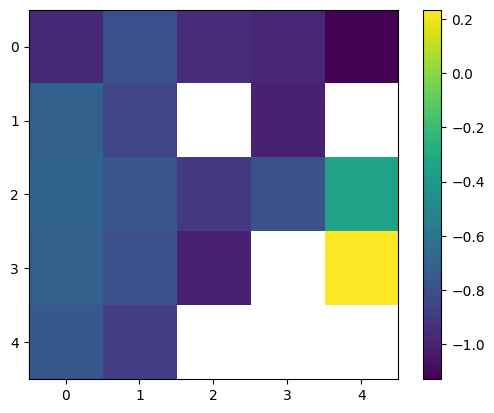

In [15]:
height = 5
width = 5
g = GridWorld(height, width, complex=True)
print(g)
V = monte_carlo_simulation(g, Agent(), 0.95, 500)
print_matrix(V)
plt.imshow(V)
plt.colorbar()
plt.show()

-1.107	-0.897	-1.047	-0.980	-1.227	
-0.823	-0.951	-inf	-0.852	-inf	
-0.820	-0.861	-0.884	-0.485	0.221	
-0.880	-0.973	-1.148	-inf	0.711	
-0.952	-1.080	-inf	-inf	-inf	


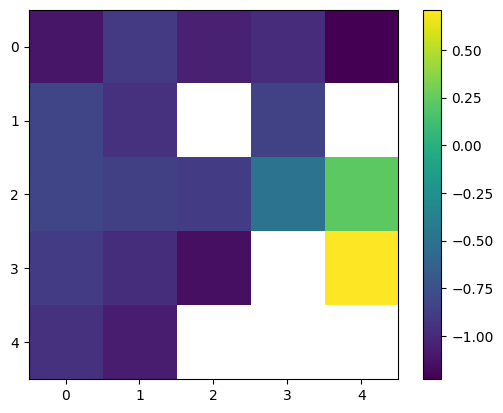

In [16]:
V = monte_carlo_simulation(g, MagneticAgent(g.win_state), 0.95, 500)
print_matrix(V)
plt.imshow(V)
plt.colorbar()
plt.show()